In [7]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import PolynomialFeatures, RobustScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer

import xgboost 
from sklearn import set_config
set_config(transform_output="pandas")
pd.set_option('display.max_columns', 500)

In [ ]:
from db.database_mysql import engine

df = pd.read_sql_query('''SELECT jp.raw_title, 
        YEAR(jp.date) AS year, 
        MONTH(jp.date) AS month, 
        DAY(jp.date) AS day, 
        im.director, im.date,im.casting, im.distributor, im.genre, jp.country, jp.duration, jp.first_day, jp.first_week, jp.first_weekend, jp.hebdo_rank, 
jp.total_spectator, jp.copies, im.rating_press, im.budget, im.lang, im.award 
FROM films_jp as jp
LEFT JOIN films_imdb im ON im.id_jp = jp.id 
where im.id_jp is not null and im.date = jp.date
order by jp.first_week desc''', engine)

# CREATION DES SCORES

In [8]:
from modelisation.functions import *

clone = df.copy()
calculate_director_scores(clone)
calculate_distributor_scores(clone)
calculate_actor_scores(clone)
calculate_year_scores(clone)
calculate_country_scores(clone)
print()

In [ ]:
from modelisation.functions import *

entree_transformer = FunctionTransformer(classify_entrees_year, kw_args={'column' : 'year'})
season_transformer = FunctionTransformer(classify_season,  kw_args={'column' : 'month'})
month_transformer = FunctionTransformer(classify_month_name,  kw_args={'column' : 'month'})
holiday_transformer = FunctionTransformer(is_holiday)

pipe_scores = Pipeline([
  ('season_dict' , make_pipeline(season_transformer)),
  ('entree_dict' , make_pipeline(entree_transformer)),
  ('month_dict' , make_pipeline(month_transformer)),
  ('holiday_dict' , make_pipeline(holiday_transformer)),
])

scores = df.copy()
scores = pipe_scores.fit_transform(scores)
scores.head(1)

# MODELE

In [ ]:
# film = pd.read_sql_query('''SELECT 
#                               YEAR(date) AS year, 
#                               MONTH(date) AS month, 
#                               DAY(date) AS day, 
#                               director, distributor, casting, copies, duration, country
#                             FROM functionalities_filmscrap
#                             LIMIT 1
#                          ''', engine)
# film

In [14]:
from modelisation.converter import *

entree_converter = FunctionTransformer(convert_entrees_year, kw_args={'column' : 'year'})
country_converter = FunctionTransformer(convert_country, kw_args={'column' : 'country'})
season_converter = FunctionTransformer(classify_season,  kw_args={'column' : 'month'})
month_converter = FunctionTransformer(classify_month_name,  kw_args={'column' : 'month'})
holiday_converter = FunctionTransformer(is_holiday)
director_converter = FunctionTransformer(convert_director, kw_args={'column' : 'director'})
actor_converter = FunctionTransformer(convert_actor, kw_args={'column' : 'casting'})
distributor_converter = FunctionTransformer(convert_distributor, kw_args={'column' : 'distributor'})

def drop_after_converter(df):
  return df.drop(columns=["director", "casting", "copies", "distributor", "country", "month", "day", "year"])

drop_after_converter_pipeline = Pipeline([
  ('drop_after_converter', make_pipeline(FunctionTransformer(drop_after_converter)))
])

ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False, dtype=int)

ohe_transformer = ColumnTransformer(
    transformers=[
        ('categorical', ohe, ['season', 'month_name'])
    ],
    remainder='passthrough'
)

pipe = Pipeline([
  ('actor_converter' , make_pipeline(actor_converter)),
  ('entree_converter' , make_pipeline(entree_converter)),
  ('season_converter' , make_pipeline(season_converter)),
  ('country_converter' , make_pipeline(country_converter)),
  ('month_converter' , make_pipeline(month_converter)),
  ('holiday_converter' , make_pipeline(holiday_converter)),
  ('director_converter' , make_pipeline(director_converter)),
  ('distributor_converter' , make_pipeline(distributor_converter)),
  ('drop' , make_pipeline(drop_after_converter_pipeline))
])

# leroy = pd.DataFrame({
#     'year': [2024],
#     'day': [10],
#     'month': [4],
#     'duration': [6120],
#     'country': ['france'],
#     'copies': [414],
#     #'genre': ['comedie'],
#     'director': ['"florent bernard"'],
#     'distributor': [["nolita cinema", "tf1 studio", "apollo films"]],
#     'casting': [["charlotte gainsbourg", "jose garcia", "lily aubry"]],
# })

# t = df.copy()
# p = pipe.fit_transform(leroy)
# p
# t.drop(columns=['raw_title', 'date', 'genre', 'budget', 'total_spectator', 'first_day', 'first_weekend', 'hebdo_rank', 'total_spectator', 'rating_press', 'award', 'lang'], inplace=True)
# p = pipe.fit_transform(t)
# p[p.isna().any(axis=1)]


# Pipe de conversion des data

In [15]:
df_clean = df.copy() 
df_clean.drop(columns=['raw_title', 'date', 'genre', 'budget', 'total_spectator', 'first_day', 'first_weekend', 'hebdo_rank', 'total_spectator', 'rating_press', 'award', 'lang'], inplace=True)

X = df_clean.drop(['first_week'], axis=1)
y = df_clean.first_week

X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, train_size=0.85, random_state=42)

pipe_transform = make_pipeline(pipe)

p = pipe_transform.transform(X)

convert_actor
convert_entrees_year 2008
convert_country france
convert_director
convert_distributor


In [16]:

X_train, X_test, y_train, y_test = train_test_split(p, y, shuffle=True, train_size=0.85, random_state=42)

model = make_pipeline(
  ohe_transformer,
  PolynomialFeatures(),
  RobustScaler(with_centering=False),
  xgboost.XGBRegressor(n_estimators=1000, max_depth=7, eta=0.1, subsample=0.7, colsample_bytree=0.8)
)

model.fit(X_train, y_train)
# m = model.fit_transform(X_train)
# m

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('categorical',
                                                  OneHotEncoder(dtype=<class 'int'>,
                                                                handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['season', 'month_name'])])),
                ('polynomialfeatures', PolynomialFeatures()),
                ('robustscaler', RobustScaler(with_centering=False)),
                ('xgbregressor',
                 XGBRegressor(base_score=...
                              eval_metric=None, feature_types=None, gamma=None,
                              grow_policy=None, importance_type=None,
                              interaction_constraints=None, learning_rate=None,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=7, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, multi_strategy=None,
                              n_estimators=1000, n_jobs=None,
                              num_parallel_tree=None, ...))])

Performance du modèle :
R2 Score: 0.2796
MAE: 201559.31
RMSE: 331721.12


<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

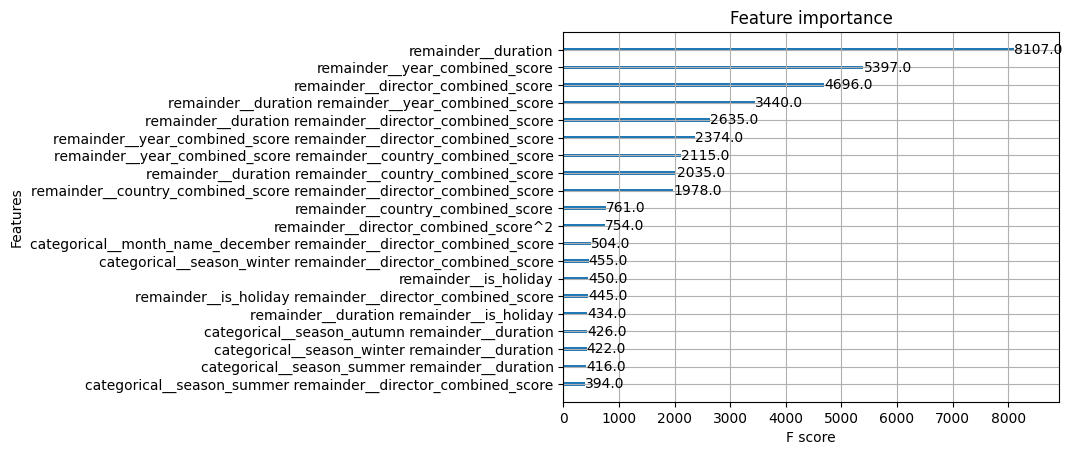

In [17]:
y_pred = model.predict(X_test)

r2_cleaned = r2_score(y_test, y_pred)
mse_cleaned = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse_cleaned = np.sqrt(mse_cleaned)

print("Performance du modèle :")
# print(model.best_params_)
print(f"R2 Score: {r2_cleaned:.4f}")
print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse_cleaned:.2f}")

xgboost.plot_importance(model[-1], max_num_features=20)

In [ ]:
display(p.head(2))
p[p.isna().any(axis=1)]

In [13]:
leroy = pd.DataFrame({
    'year': [2024],
    'day': [10],
    'month': [4],
    'duration': [6120],
    'country': ['france'],
    'copies': [414],
    #'genre': ['comedie'],
    'director': ['"florent bernard"'],
    'distributor': [["nolita cinema", "tf1 studio", "apollo films"]],
    'casting': [["charlotte gainsbourg", "jose garcia", "lily aubry"]],
})

#duration	year_combined_score	actor_combined_score	season	country_combined_score	month_name	is_holiday	director_combined_score	distributor_combined_score
transformed_data = pipe_transform.transform(leroy)
display(transformed_data)
model.predict(transformed_data)

convert_actor
convert_entrees_year 2024
convert_country france
convert_director
convert_distributor


,duration,actor_combined_score,year_combined_score,season,country_combined_score,month_name,is_holiday,director_combined_score,distributor_combined_score
0,6120,0.656811,0.440816,spring,0.716108,april,0,0,0


array([93500.21], dtype=float32)